In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
import string
import nltk
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Exploration

In [2]:
fake = pd.read_csv('Fake.csv') # Membaca file Fake.csv
fake.head() # Menampilkan data paling awal

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [3]:
fake.info() # Menampilkan informasi data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [4]:
true = pd.read_csv('True.csv') # Membaca file True.csv
true.head() # Menampilkan data paling awal

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
true.info() # Menampilkan informasi data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [6]:
# Menambahkan kolom 'Label' berupa '0' dan '1'
fake['label'] = 0
true['label'] = 1

In [7]:
# Menggabungkan data fake dan true
df = pd.concat([fake, true])

In [8]:
# Randomisasi data
df = df.sample(frac = 1)

In [9]:
df.head() # Menampilkan data paling awal

,title,text,subject,date,label
1287,Republicans eye alternatives for getting to 20...,WASHINGTON (Reuters) - Republican lawmakers ar...,politicsNews,"October 12, 2017",1
2003,WATCH: Joy Reid And Panel RIP House Intel Cha...,An examination of Republican House Intelligenc...,News,"March 25, 2017",0
18558,Catalan leader opens door to secession from Sp...,BARCELONA (Reuters) - Catalonia s regional lea...,worldnews,"October 1, 2017",1
17961,U2 SUDDENLY CANCELS Huge St. Louis Concert Ton...,"In 2016, celebrities came together to create a...",left-news,"Sep 16, 2017",0
79,Trump’s Favorite News Channel Tries To Soothe...,"Yesterday, after the father of one of the UCLA...",News,"November 20, 2017",0


<AxesSubplot:xlabel='label', ylabel='count'>

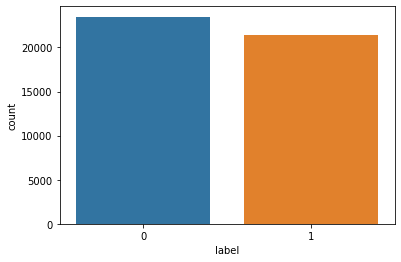

In [10]:
sns.countplot(x='label', data = df) # Visualisasi perbandingan data

## Data Preprocessing

In [11]:
df['news'] = df['title'] + ' ' + df['text'] # Gabungkan kolom title dan text
df.drop(['subject', 'date', 'title', 'text'], axis=1, inplace=True) # Drop kolom yang tidak diperlukan
df = df[['news', 'label']] # Reorder kolom

In [12]:
df.head()

,news,label
1287,Republicans eye alternatives for getting to 20...,1
2003,WATCH: Joy Reid And Panel RIP House Intel Cha...,0
18558,Catalan leader opens door to secession from Sp...,1
17961,U2 SUDDENLY CANCELS Huge St. Louis Concert Ton...,0
79,Trump’s Favorite News Channel Tries To Soothe...,0


In [13]:
# Mendefisinikan fungsi preprocessing text
stop = nltk.corpus.stopwords.words('english') # Mendefinisikan stopwords
stemmer = nltk.stem.SnowballStemmer('english') # Mendefinisikan stemmer
tanda_baca = []
tanda_baca += list(string.punctuation) # Daftar tanda baca bawaan Python
tanda_baca += '’' # Tambahkan tanda kutip tunggal
tanda_baca += '“' # Tambahkan tanda kutip ganda
def preprocess(text):
    text = text.lower() # Menjadikan text lowercase
    text = text.translate(str.maketrans('', '', ''.join(tanda_baca))) # Menghapus tanda baca
    text = text.replace('\n', ' ') # Menghapus whitespace
    text = re.sub(r'\d+', '', text) # Menghapus angka
    text = re.sub('http://\S+|https://\S+', '', text) # Menghapus URL
    text = ' '.join([word for word in text.split() if word not in stop]) # Menghapus stopwords
    text = ' '.join([stemmer.stem(word) for word in text.split()]) # Menjadikan kata dasar
    return text


In [14]:
df['news_clean'] = df['news'].apply(preprocess) # Preprocessing text

In [15]:
df.head()

,news,label,news_clean
1287,Republicans eye alternatives for getting to 20...,1,republican eye altern get percent corpor tax r...
2003,WATCH: Joy Reid And Panel RIP House Intel Cha...,0,watch joy reid panel rip hous intel chair trum...
18558,Catalan leader opens door to secession from Sp...,1,catalan leader open door secess spain vote bar...
17961,U2 SUDDENLY CANCELS Huge St. Louis Concert Ton...,0,u sudden cancel huge st loui concert tonight…w...
79,Trump’s Favorite News Channel Tries To Soothe...,0,trump favorit news channel tri sooth batter eg...


In [16]:
x_train, x_test, y_train, y_test = train_test_split(df['news_clean'], df['label'], test_size=0.20, random_state=42) # Membagi data training dan testing

In [17]:
vectorization = CountVectorizer()
xv_train = vectorization.fit_transform(x_train)
xv_test = vectorization.transform(x_test)

## Build Machine Learning Model

In [18]:
rf = RandomForestClassifier() # Mendefinisikan model Random Forest
svc = SVC() # Mendefinisikan model SVC
xgb = GradientBoostingClassifier() # Mendefinisikan model XGBoost   

In [19]:
rf.fit(xv_train, y_train) # Training model Random Forest
pred_rf = rf.predict(xv_test) # Prediksi model Random Forest
print(classification_report(y_test, pred_rf)) # Menampilkan report classification
print(confusion_matrix(y_test, pred_rf)) # Menampilkan confusion matrix

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4685
           1       0.99      0.99      0.99      4295

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

[[4633   52]
 [  54 4241]]


In [20]:
svc.fit(xv_train, y_train) # Training model SVC
pred_svc = svc.predict(xv_test) # Prediksi model SVC
print(classification_report(y_test, pred_svc)) # Menampilkan report classification
print(confusion_matrix(y_test, pred_svc)) # Menampilkan confusion matrix

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4685
           1       1.00      0.99      0.99      4295

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

[[4665   20]
 [  27 4268]]


In [21]:
xgb.fit(xv_train, y_train) # Training model XGBoost
pred_xgb = xgb.predict(xv_test) # Prediksi model XGBoost
print(classification_report(y_test, pred_xgb)) # Menampilkan report classification
print(confusion_matrix(y_test, pred_xgb)) # Menampilkan confusion matrix

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4685
           1       0.99      1.00      1.00      4295

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

[[4655   30]
 [  11 4284]]


## Menggunakan Model BERT dengan Fine Tuning

In [22]:
# Split data training dan testing untuk model BERT
x_train, x_test, y_train, y_test = train_test_split(df['news'], df['label'], test_size=0.20, random_state=42) # Membagi data training dan testing

In [23]:
# Preprocessing text dengan BERT
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

In [24]:
# Mendefinisikan model BERT cuman menggunakan bagian output
layer = tf.keras.layers.Dropout(0.2, name="dropout")(outputs['pooled_output'])
layer = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(layer)

In [25]:
# Menggunakan input text dan output layer
model = tf.keras.Model(inputs=[text_input], outputs = [layer])

In [26]:
# Finetuning model BERT
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=3, batch_size = 256, validation_data=(x_test, y_test), verbose=1)

Epoch 1/3
141/141 [==============================] - 4803s 34s/step - loss: 0.5414 - accuracy: 0.7430 - val_loss: 0.3863 - val_accuracy: 0.8980
Epoch 2/3
141/141 [==============================] - 4863s 35s/step - loss: 0.3478 - accuracy: 0.8825 - val_loss: 0.2884 - val_accuracy: 0.9173
Epoch 3/3
141/141 [==============================] - 4854s 34s/step - loss: 0.2790 - accuracy: 0.9073 - val_loss: 0.2411 - val_accuracy: 0.9259


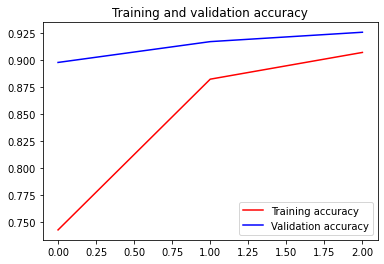

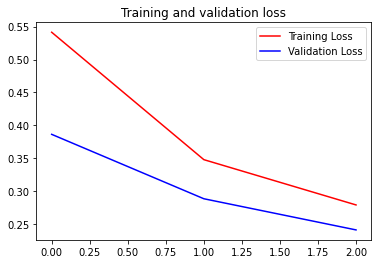

In [27]:
# Visualisasi training dan validasi
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()